In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import glob
from PIL import Image
import imageio


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

output_path = "/kaggle/working/"

warnings.filterwarnings("ignore")

/kaggle/input/xspaa-data/event_predictions.csv
/kaggle/input/xspaa-data/test_set.csv
/kaggle/input/xspaa-data/training_set.csv
/kaggle/input/xspaa-data/points_data.csv


In [2]:
event_predictions = pd.read_csv("../input/xspaa-data/event_predictions.csv")
points_data = pd.read_csv("../input/xspaa-data/points_data.csv") 

points_data["returner"] = np.where(points_data.rallyid == 196, "Nadal", points_data.returner)

# Prepare Data 

In [3]:
# Rename columns
event_predictions_renamed = event_predictions.rename(columns = {
    "server_x": "server_y",
    "server_y": "server_x",
    "receiver_x": "receiver_y",
    "receiver_y": "receiver_x"
})

event_predictions_join = pd.merge(points_data[["rallyid", "server", "returner"]], 
                                  event_predictions_renamed, on = "rallyid")

# Create hitter, receiver names column
event_predictions_join["hitter"] = np.where(event_predictions_join.strokeid % 2 == 0, 
                                            event_predictions_join.returner, event_predictions_join.server)
event_predictions_join["receiver"] = np.where(event_predictions_join.strokeid % 2 == 0, 
                                             event_predictions_join.server, event_predictions_join.returner)

In [4]:
# Encode "ball position" using hitter location, conditional on strokeid
ball_pos = event_predictions_join[["rallyid", "strokeid", "hitter", "receiver", 
                                   "server_x", "server_y", "receiver_x", "receiver_y"]]

ball_pos["ball_x"] = np.where(ball_pos.strokeid % 2 == 1, ball_pos.server_x, ball_pos.receiver_x)
ball_pos["ball_y"] = np.where(ball_pos.strokeid % 2 == 1, ball_pos.server_y, ball_pos.receiver_y)

# Create new variables for player positions
ball_pos["nadal_x"] = np.where(ball_pos.hitter == "Nadal", ball_pos.ball_x, np.nan)
ball_pos["nadal_y"] = np.where(ball_pos.hitter == "Nadal", ball_pos.ball_y, np.nan)

ball_pos["djokovic_x"] = np.where(ball_pos.hitter == "Djokovic", ball_pos.ball_x, np.nan)
ball_pos["djokovic_y"] = np.where(ball_pos.hitter == "Djokovic", ball_pos.ball_y, np.nan)

ball_pos.drop(["receiver_x", "receiver_y"], axis = 1, inplace = True)

In [5]:
# Fill the new variables with starting positions for the return player
event_predictions_receiver_locs = event_predictions_join[["rallyid", "strokeid", "receiver_x", "receiver_y"]]

# Join data with receiver locations, create Nadal and Djokovic location columns
ball_player_pos = pd.merge(ball_pos, event_predictions_receiver_locs, on = ["rallyid", "strokeid"], how = "left")

ball_player_pos["nadal_x"] = np.where((ball_player_pos.strokeid == 1) & (ball_player_pos.receiver == "Nadal"), 
                                      ball_player_pos.receiver_x, ball_player_pos.nadal_x)

ball_player_pos["nadal_y"] = np.where((ball_player_pos.strokeid == 1) & (ball_player_pos.receiver == "Nadal"), 
                                      ball_player_pos.receiver_y, ball_player_pos.nadal_y)

ball_player_pos["djokovic_x"] = np.where((ball_player_pos.strokeid == 1) & (ball_player_pos.receiver == "Djokovic"), 
                                      ball_player_pos.receiver_x, ball_player_pos.djokovic_x)

ball_player_pos["djokovic_y"] = np.where((ball_player_pos.strokeid == 1) & (ball_player_pos.receiver == "Djokovic"), 
                                      ball_player_pos.receiver_y, ball_player_pos.djokovic_y)

In [6]:
def update_positions(df):
    """
    Purpose: Update player positions with the end positions of a rally.

    Input(s):
        df (pd.DataFrame): DataFrame containing rally data.

    Output(s):
        df (pd.DataFrame): Updated DataFrame with player positions filled.
    """
    
    df = df.sort_values(by=['rallyid', 'strokeid'])
    
    for rallyid, group in df.groupby('rallyid'):
        for idx, row in group.iterrows():
            if row['strokeid'] == group['strokeid'].max() and row['strokeid'] != 1:
                if row['receiver'] == 'Nadal':
                    df.loc[idx, 'nadal_x'] = group.loc[group['strokeid'] == row['strokeid'] - 1, 'nadal_x'].values[0]
                    df.loc[idx, 'nadal_y'] = group.loc[group['strokeid'] == row['strokeid'] - 1, 'nadal_y'].values[0]
                if row['receiver'] == 'Djokovic':
                    df.loc[idx, 'djokovic_x'] = group.loc[group['strokeid'] == row['strokeid'] - 1, 'djokovic_x'].values[0]
                    df.loc[idx, 'djokovic_y'] = group.loc[group['strokeid'] == row['strokeid'] - 1, 'djokovic_y'].values[0]
    return df

def interpolate_positions(df):
    """
    Purpose: Interpolate player positions between each hit.

    Input(s):
        df (pd.DataFrame): DataFrame containing rally data.

    Output(s):
        df (pd.DataFrame): Updated DataFrame with interpolated player positions.
    """
    
    for rallyid, group in df.groupby('rallyid'):
        group = group.reset_index()
        for i, row in group.iterrows():
            if pd.isna(row['nadal_x']) and i > 0 and i < len(group) - 1:
                df.loc[row['index'], 'nadal_x'] = (group.loc[i-1, 'nadal_x'] + group.loc[i+1, 'nadal_x']) / 2
            if pd.isna(row['nadal_y']) and i > 0 and i < len(group) - 1:
                df.loc[row['index'], 'nadal_y'] = (group.loc[i-1, 'nadal_y'] + group.loc[i+1, 'nadal_y']) / 2
            if pd.isna(row['djokovic_x']) and i > 0 and i < len(group) - 1:
                df.loc[row['index'], 'djokovic_x'] = (group.loc[i-1, 'djokovic_x'] + group.loc[i+1, 'djokovic_x']) / 2
            if pd.isna(row['djokovic_y']) and i > 0 and i < len(group) - 1:
                df.loc[row['index'], 'djokovic_y'] = (group.loc[i-1, 'djokovic_y'] + group.loc[i+1, 'djokovic_y']) / 2
    return df

ball_player_pos = update_positions(ball_player_pos)
ball_player_pos = interpolate_positions(ball_player_pos)

In [7]:
# Gather data for points, event probabilities
points_data_join = points_data[["rallyid", "score"]]

event_pred_probas = event_predictions_join[["rallyid", "strokeid", "prob"]]

# Add in event probabilities and game score
ball_player_pos_data = pd.merge(ball_player_pos, points_data_join, on = "rallyid")
ball_player_pos_data = pd.merge(ball_player_pos_data, event_pred_probas, on = ["rallyid", "strokeid"])

ball_player_pos_data["prob"] = round(ball_player_pos_data.prob * 100, 1)

# Create GIFs

In [8]:
# Initialize global variables
height_court = 11.89*2
width_court = 10.97

service_box = 6.4
double_field = 1.37
baseline_serviceline = 5.5
breite_einzel = 8.23
serviceline_net = 6.4

def create_discrete_colormap(n, base_cmap=None):
    """    
    Purpose: Create discrete color mapping for column listed 1-N

    Input(s):
        n (int): Number of discrete colors to create in the colormap.
        base_cmap (str or None): The name of the base colormap to use. If None, the default colormap is used.
    
    Output(s):
        LinearSegmentedColormap: A discrete colormap with `n` discrete colors.
    """
    
    # Get the base colormap from matplotlib
    base = plt.cm.get_cmap(base_cmap)
    
    # Generate `n` evenly spaced colors from the base colormap
    color_list = base(np.linspace(0, 1, n))
    
    # Create a unique name for the discrete colormap
    cmap_name = base.name + str(n)

    # Create a discrete colormap from the color list
    discrete_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, color_list, n)
    
    return discrete_cmap

def draw_court_horz(hide_axes=True):
    """
    Purpose: Draw tennis court visual with optional hidden axes.
    (Code courtesy of https://www.kaggle.com/code/robseidl/australian-open-mens-final-2019-data-exploration)

    Input(s):
        hide_axes (bool): If True, the axes will be hidden. Default is False.
    
    Output(s):
        fig, axes (tuple): Contains the figure and axes objects.
    """
    
    # Create a figure with specified size based on court dimensions
    fig = plt.figure(figsize=(height_court/2, width_court/2))
    
    # Alternative figure size (commented out)
    # fig = plt.figure(figsize=(9, 9))
    fig.patch.set_facecolor('#5080B0')

    # Add subplot with a specified background color
    axes = fig.add_subplot(1, 1, 1, facecolor='#5080B0')

    # Optionally hide the axes
    if hide_axes:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.axis('off')

    # Draw court patches on the axes
    axes = draw_patches(axes)
    
    return fig, axes

def draw_patches(axes):
    """
    Purpose: Draw the various patches and lines of the tennis court

    Input(s):
        axes (matplotlib.axes.Axes): The axes on which to draw the patches

    Output(s):
        axes (matplotlib.axes.Axes): The axes with the patches added
    """
    
    # Set the limits for the x and y axis based on court dimensions
    plt.ylim([-1, 13])
    plt.xlim([-4, 28])
    
    # Add the line for the net
    axes.add_line(plt.Line2D(
                             [height_court / 2, height_court / 2], 
                             [0, width_court], 
                             c='w'))
    
    # Add the court outline
    y = 0
    dy = width_court
    x = 0
    dx = height_court
    axes.add_patch(plt.Rectangle((x, y), dx, dy, edgecolor="white", facecolor="#5581A6", alpha=1))
    
    x = height_court / 4
    y = 1.37

    dy = width_court - 1.37*2
    dx = height_court / 2
    # Draw the serving rectangle
    axes.add_patch(plt.Rectangle((x, y), dx, dy, edgecolor="white", facecolor="none", alpha=1))
    
    # Add the service box line
    axes.add_line(plt.Line2D([height_court / 4, 3*height_court / 4], [width_court / 2, width_court / 2], c='w'))

    # Add the single side lines
    axes.add_line(plt.Line2D([0, height_court], [1.37, 1.37], c='w'))
    axes.add_line(plt.Line2D([0, height_court], [width_court - 1.37, width_court - 1.37], c='w'))

    # Add the center hash marks at the baselines
    axes.add_line(plt.Line2D([0, 0 + 0.45], [width_court / 2, width_court / 2], c='w'))
    axes.add_line(plt.Line2D([height_court - 0.45, height_court], [width_court / 2, width_court / 2], c='w'))

    return axes

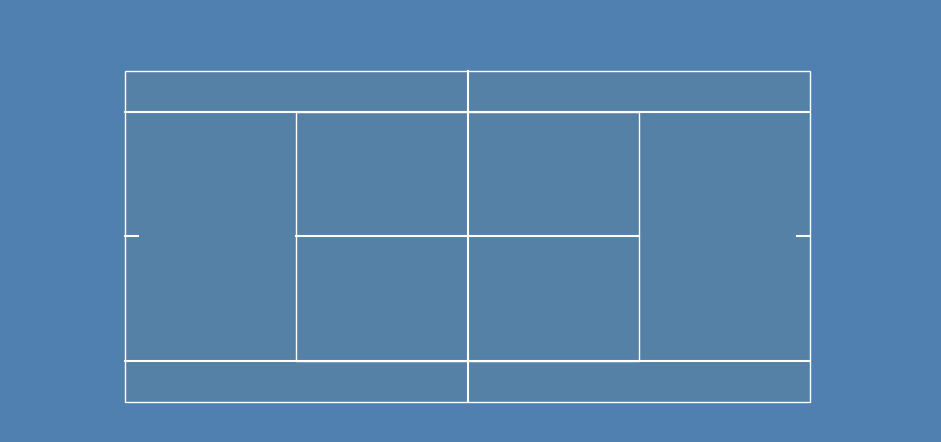

In [9]:
fig, ax = draw_court_horz();

In [10]:
# Function to create a frame for each transition
def create_frame(x1i, y1i, x2i, y2i, xbi, ybi, server_wins_prob, current_stroke, num_strokes, frame_num):
    """
    Purpose: For inputs of player, ball locations plus other event info, plot locations and write event info to a court, save as a snapshot image in time

    Input(s):
        x1i, y1i, x2i, y2i, xbi, ybi (float64): (x, y) coordinate values for players, ball locations
        server_wins_prob (float64): Individual event/transition probability of server winning the point
        current_stroke (int): Denotes the number of stroke in the rally (cannot be greater than num_strokes)
        num_strokes (int): Number of strokes in each rally
        frame_num (int): Denotes the number frame for the entire GIF

    Output(s):
        None
    """

    # Draw court for each frame
    fig, ax = draw_court_horz();

    # Plot player and ball locations
    plt.scatter(x1i, y1i, color = "orange", s = 100)
    plt.scatter(x2i, y2i, color = "white", s = 100)
    plt.scatter(xbi, ybi, color = "#dfff4f", s = 15)

    # Plot labels for players, probability, and stroke number
    ax.text(x1i, y1i, "N", ha = 'center', va = 'center', fontsize = 12)
    ax.text(x2i, y2i, "D", ha = 'center', va = 'center', fontsize = 12)
    ax.set_title(f"Probability, Server Wins: {server_wins_prob}%", ha = "center", color = "white")
    ax.text(11.985, 12, f"Stroke {current_stroke} of {num_strokes}", color='white', ha='center')
    
    # Save plot as an individual frame
    plt.grid(True)
    plt.savefig(f'frame_{frame_num}.png')
    plt.close()

def create_gif(xy_player1, xy_player2, xy_ball, event_probs, n_strokes, frames_per_transition=20, filename='test.gif', duration=1):
    """
    Purpose: With players, ball location over time plus event info, create GIF of each event as well as transitions

    Input(s):
        xy_player1, xy_player2, xy_ball (np.array): Arrays of player, ball location data
        event_probs (list): Contains probability of server winning the point after each hit
        n_strokes (int): Number of strokes in each rally
        frames_per_transition (int): Default 20, determines number of transition states between each row of location data
        filename (string): Default 'test.gif,' name of GIF upon saving
        duration (int): Default 1, sets duration of GIF with all saved frames

    Output(s):
        None
    """

    # Isolate players, ball x and y data
    player1_x = xy_player1[0]
    player1_y = xy_player1[1]

    player2_x = xy_player2[0]
    player2_y = xy_player2[1]

    ball_x = xy_ball[0]
    ball_y = xy_ball[1]
    
    frames_list = []
    total_points = len(xy_player1[0])
    total_frames = frames_per_transition * (total_points - 1)

    # Iterating through N - 1 strokes for each point
    for point_index in range(total_points - 1):

        # Filter for n and n + 1 location data for players, ball, as well as probability and stroke number
        x1_start, x1_end = player1_x[point_index], player1_x[point_index + 1]
        y1_start, y1_end = player1_y[point_index], player1_y[point_index + 1]

        x2_start, x2_end = player2_x[point_index], player2_x[point_index + 1]
        y2_start, y2_end = player2_y[point_index], player2_y[point_index + 1]

        ball_x_start, ball_x_end = ball_x[point_index], ball_x[point_index + 1]
        ball_y_start, ball_y_end = ball_y[point_index], ball_y[point_index + 1]

        prob = event_probs[point_index]

        stroke_num = point_index + 1

        # Create intermediate steps between start and end positions
        x1_transition = np.linspace(x1_start, x1_end, frames_per_transition)
        y1_transition = np.linspace(y1_start, y1_end, frames_per_transition)

        x2_transition = np.linspace(x2_start, x2_end, frames_per_transition)
        y2_transition = np.linspace(y2_start, y2_end, frames_per_transition)

        ball_x_transition = np.linspace(ball_x_start, ball_x_end, frames_per_transition)
        ball_y_transition = np.linspace(ball_y_start, ball_y_end, frames_per_transition)

        # For each segment between each event
        for frame_segment in range(frames_per_transition):
            # Create scatterplot with locations, event info and add as a frame to be joined together
            create_frame(x1_transition[frame_segment], y1_transition[frame_segment], 
                         x2_transition[frame_segment], y2_transition[frame_segment], 
                         ball_x_transition[frame_segment], ball_y_transition[frame_segment], 
                         prob, stroke_num, n_strokes,
                         point_index * frames_per_transition + frame_segment + 1)
            frames_list.append(imageio.imread(f'frame_{point_index * frames_per_transition + frame_segment + 1}.png'))

    # For final stroke of each event, isolate location and event info
    final_index = total_points - 1
    
    x1_final = player1_x[final_index]
    y1_final = player1_y[final_index]

    x2_final = player2_x[final_index]
    y2_final = player2_y[final_index]

    ball_x_final = ball_x[final_index]
    ball_y_final = ball_y[final_index]
    
    prob_final = event_probs[final_index]

    final_frame_num = total_frames + 1

    # Create one more frame to complete rally GIF
    create_frame(x1_final, y1_final, x2_final, y2_final, ball_x_final, ball_y_final, prob_final, total_points, n_strokes, final_frame_num)
    frames_list.append(imageio.imread(f'frame_{final_frame_num}.png'))

    # Combine all frames in list of frames to create GIF for rally
    imageio.mimsave(filename, frames_list, duration=duration)

    # Remove saved frames from directory
    for frame_number in range(1, len(frames_list) + 1):
        os.remove(f'frame_{frame_number}.png')


In [11]:
# Assuming 'ball_player_pos_data' is a pandas DataFrame and 'rallies_to_animate' is a list of rally IDs
rallies = ball_player_pos_data["rallyid"].drop_duplicates().tolist()

# Create dataframe with number of strokes per rally
rally_strokes_df = ball_player_pos_data.groupby("rallyid").strokeid.max().reset_index(name = "strokes")

In [ ]:
# Iterating for rallies in final four games
for rally in rallies:
    print(f"Rally {rally}")

    # Filter for event-level data, isolate variables for each rally
    rally_data = ball_player_pos_data[ball_player_pos_data.rallyid == rally]

    rally_n_strokes = rally_strokes_df[rally_strokes_df.rallyid == rally].strokes.values[0]

    probabilities = rally_data.prob.tolist()
    
    nadal_data = np.array([rally_data.nadal_x, rally_data.nadal_y])

    djokovic_data = np.array([rally_data.djokovic_x, rally_data.djokovic_y])

    ball_data = np.array([rally_data.ball_x, rally_data.ball_y])
    
    # Create GIF
    create_gif(nadal_data, djokovic_data, ball_data, probabilities, rally_n_strokes, filename=f'animation_{rally}.gif')

# Create Shiny App Data

In [15]:
# Filter for data in final four games, prepare dataframe for rally info
app_points_data = points_data[points_data.rallyid >= 169].rename(columns = {"score": "end_score"})

app_points_data["start_score"] = app_points_data["end_score"].shift(1).fillna("6:3 6:2 3:2, 0:0")

app_points_data["rally_select_name"] = app_points_data.apply(lambda row: "Rally " + str(row["rallyid"]) + ": " + row["start_score"], axis=1)

In [16]:
# Isolate results of each rally
rally_results = app_points_data[["rallyid", "rally_select_name", "start_score", "server", "returner", 
                                 "winner", "ServerWinsPoint", "reason"]]

# Create dataframe for important rally info (e.g. server, winner, xSPW)
app_event_preds_data = pd.merge(
    event_predictions.groupby("rallyid").strokeid.max().reset_index(name = "strokes"), 
    event_predictions[["rallyid", "strokeid", "prob"]],
    left_on = ["rallyid", "strokes"], right_on = ["rallyid", "strokeid"]
)

app_event_info_data = pd.merge(app_event_preds_data, rally_results)

app_event_info_data["xSPW"] = app_event_info_data.ServerWinsPoint - app_event_info_data.prob
app_event_info_data["reason"] = app_event_info_data.reason.str.title()

app_event_info_data = app_event_info_data[["rallyid", "rally_select_name", "start_score", "server", "returner", 
                                           "winner", "reason", "xSPW"]]

In [17]:
# Write event app info to csv
app_event_info_data.to_csv(output_path + "event_predictions_app.csv", index = False)